# Notebook for developing the disease color masking technique

In [126]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [127]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
test_path = os.path.join(HOME,"test_imgs")

HOME: c:\Users\Zahra\Desktop\Cmmn_Place\Projects\TWQ_AI\Capstone\plant_disease_detection


### We're concerned with the following five diseases
1. Powdery mildew
2. Burn
3. Spots
4. Rot
5. Chlorosis

In [143]:
mildew = cv2.imread(os.path.join(test_path, "mildew.jpg"))
aziz_burn = cv2.imread(os.path.join(test_path, "Aziz_burn.jpg"))
spot = cv2.imread(os.path.join(test_path, "spot.jpg"))
rot = cv2.imread(os.path.join(test_path, "rot.jpg"))
c1 = cv2.imread(os.path.join(test_path, "c1.jpeg"))

hsv_mildew = cv2.cvtColor(mildew, cv2.COLOR_BGR2HSV)
hsv_aziz_burn = cv2.cvtColor(aziz_burn, cv2.COLOR_BGR2HSV)
hsv_spot = cv2.cvtColor(spot, cv2.COLOR_BGR2HSV)
hsv_rot = cv2.cvtColor(rot, cv2.COLOR_BGR2HSV)
hsv_c1 = cv2.cvtColor(c1, cv2.COLOR_BGR2HSV)


## We'll start by tackling the mildew

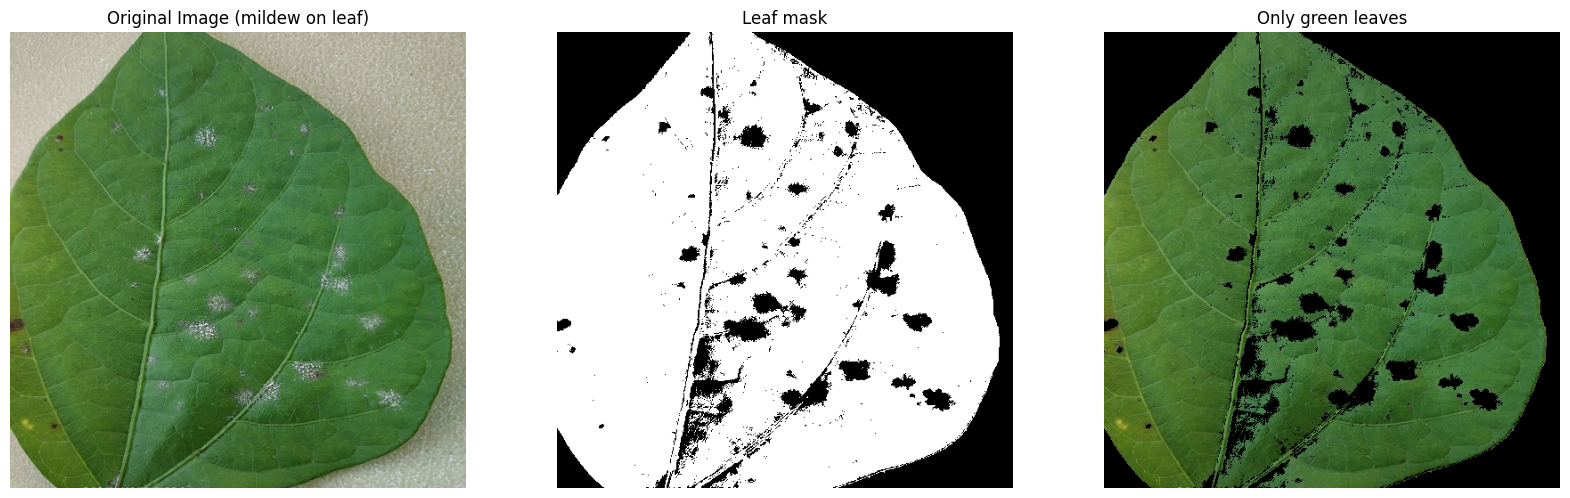

In [144]:
leaf_mask = cv2.inRange(hsv_mildew, (25, 100, 70), (65, 255, 255))

mildew_rgb = cv2.cvtColor(mildew, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(mildew_rgb)
axes[0].axis('off')
axes[0].set_title("Original Image (mildew on leaf)")

axes[1].imshow(leaf_mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Leaf mask")

axes[2].imshow(cv2.bitwise_and(mildew_rgb, mildew_rgb, mask=leaf_mask))
axes[2].axis('off')
axes[2].set_title("Only green leaves")

plt.show()

## The leaf mask adequately detects the leaf but to find the powdery mildew that lies within it, we only need the outermost contour of the leaf

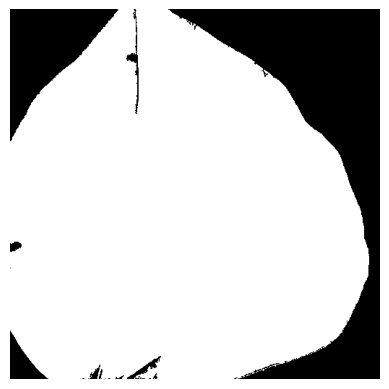

In [145]:
# Create a black 1-channel image to draw on
leaf = np.zeros(leaf_mask.shape, dtype=np.uint8)

contours, _ = cv2.findContours(leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the black image
cv2.drawContours(leaf, contours, -1, 255, cv2.FILLED)

# Display
plt.imshow(leaf, cmap='gray')
plt.axis('off')
plt.show()                                                                                         

## Now we find the mildew lying within it

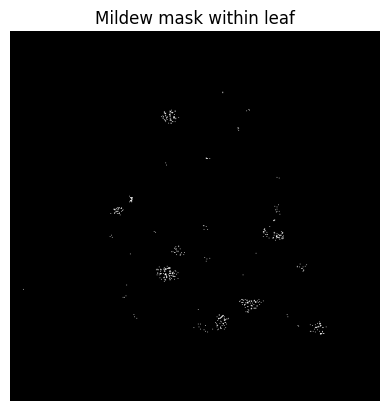

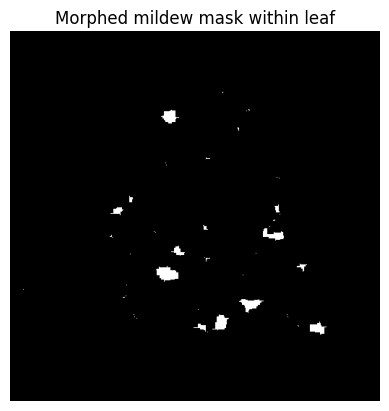

In [146]:
white_mask = cv2.inRange(hsv_mildew, (0, 0, 180), (180,  60, 255))
white_mask = cv2.bitwise_and(leaf, leaf, mask=white_mask)

# Morphing the mildew mask for better coverage
kernel = np.ones((9, 9), np.uint8)
morphed_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)


plt.imshow(white_mask, cmap='gray')
plt.axis('off')
plt.title("Mildew mask within leaf")
plt.show()
plt.imshow(morphed_mask, cmap='gray')
plt.axis('off')
plt.title("Morphed mildew mask within leaf")
plt.show()

## Now we'll tackle burns on leaves
Simply a brownish color mask is sufficient given appropraite photo conditions

***Image credit to my colleague Abdulaziz Alfrayan**

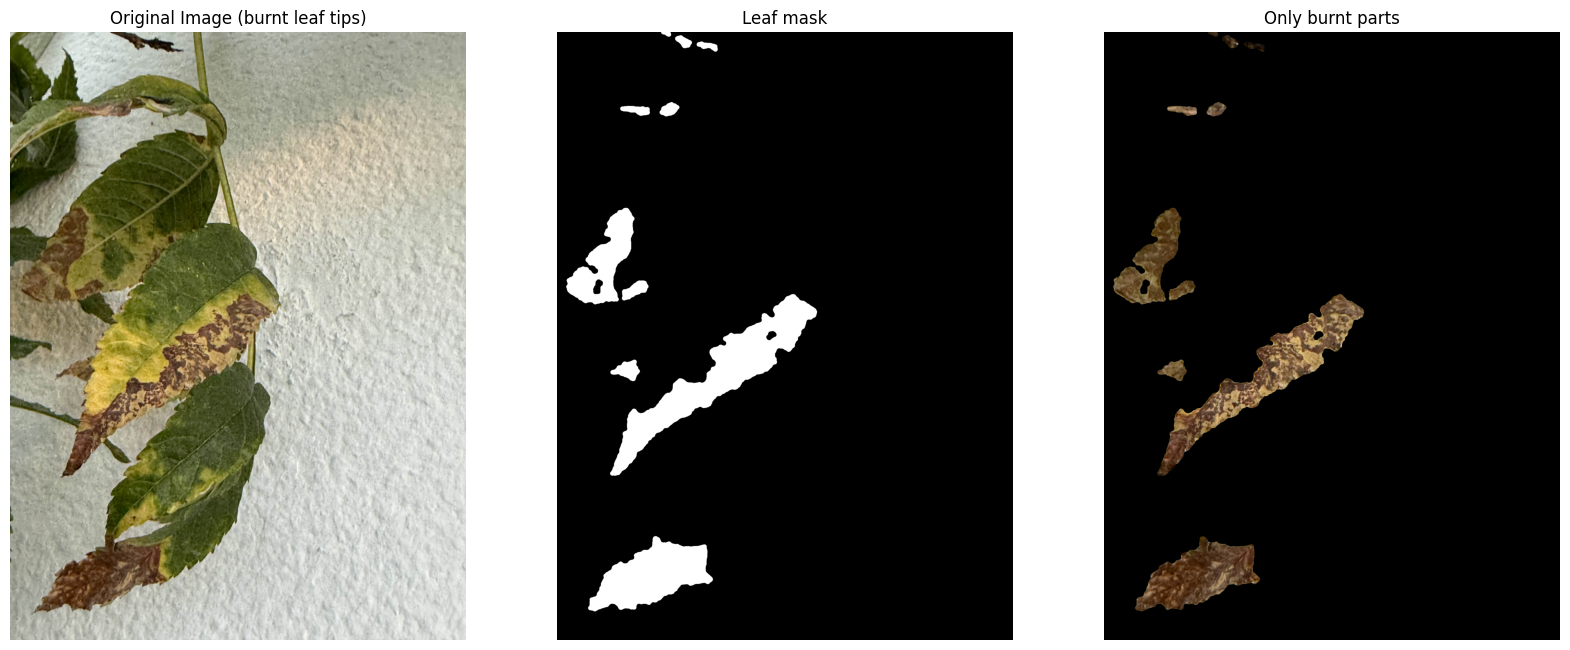

In [132]:
burn_mask = cv2.inRange(hsv_aziz_burn, (10,100,10), (20, 255, 200))

burn_rgb = cv2.cvtColor(aziz_burn, cv2.COLOR_BGR2RGB)

# Testing a more sophistcated morphology - it's better! less edges and more organic
kh, kw = [max(9, int(round(min(hsv_aziz_burn.shape[:2]) * 0.01))) | 1]*2 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kh, kw))
burn_mask = cv2.morphologyEx(burn_mask, cv2.MORPH_CLOSE, kernel)
burn_mask = cv2.morphologyEx(burn_mask, cv2.MORPH_OPEN,  kernel)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(burn_rgb)
axes[0].axis('off')
axes[0].set_title("Original Image (burnt leaf tips)")

axes[1].imshow(burn_mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Leaf mask")

axes[2].imshow(cv2.bitwise_and(burn_rgb, burn_rgb, mask=burn_mask))
axes[2].axis('off')
axes[2].set_title("Only burnt parts")
plt.show()

## Now it's time for spots, which are usually caused by fungi or bacteria
The spots typically occur within the leaf, so we'll use our handy leaf mask

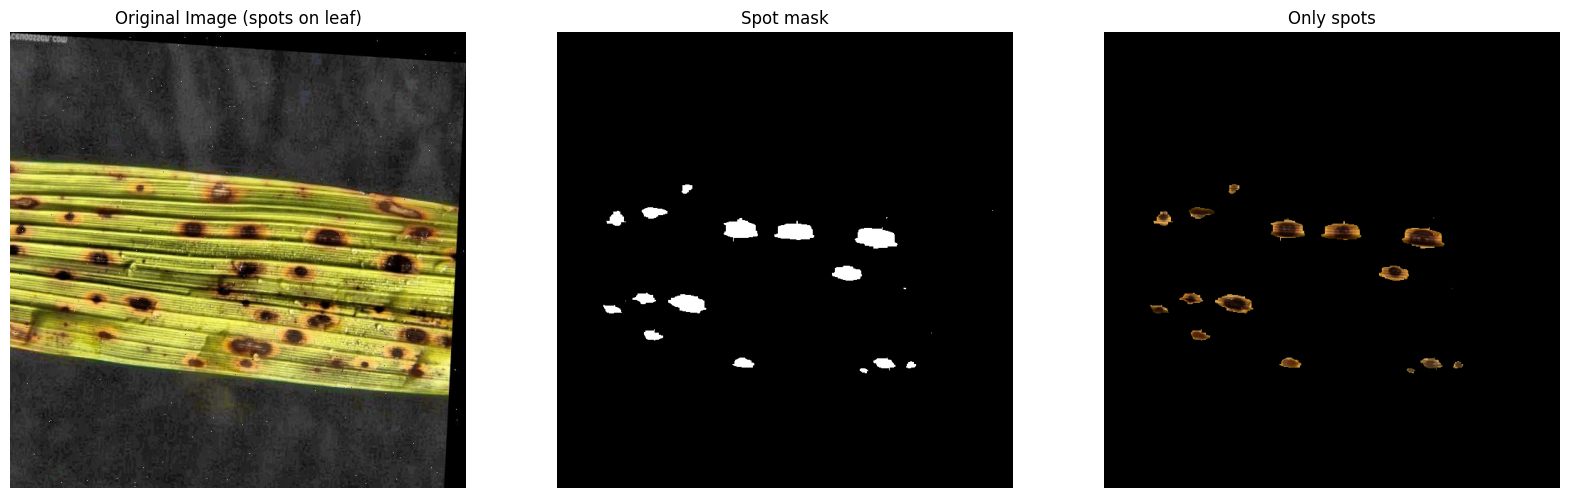

In [ ]:
leaf_mask2 = cv2.inRange(hsv_spot, (25, 100, 70), (65, 255, 255))
leaf2 = np.zeros(leaf_mask2.shape, dtype=np.uint8)

spot_rgb = cv2.cvtColor(spot, cv2.COLOR_BGR2RGB)

contours2, _ = cv2.findContours(leaf_mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the black image
cv2.drawContours(leaf2, contours2, -1, 255, cv2.FILLED)

spot_mask = cv2.inRange(hsv_spot, (10,100,10), (20, 255, 200))
spot_mask = cv2.bitwise_and(leaf2, leaf2, mask=spot_mask)

# The rectangular 9x9 kernal appeard to perform better on smaller patches of disease
kernel = np.ones((9, 9), np.uint8)
morphed_mask2 = cv2.morphologyEx(spot_mask, cv2.MORPH_CLOSE, kernel)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(spot_rgb)
axes[0].axis('off')
axes[0].set_title("Original Image (spots on leaf)")

axes[1].imshow(morphed_mask2, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Spot mask")

axes[2].imshow(cv2.bitwise_and(spot_rgb, spot_rgb, mask=morphed_mask2))
axes[2].axis('off')
axes[2].set_title("Only spots")
plt.show()

Due to the image quality of most spot training data and the porosity of the leaves, it's not possible to get a perfect mask. This mask however still guides the next steps adequately.

## Now we get to foliage rot

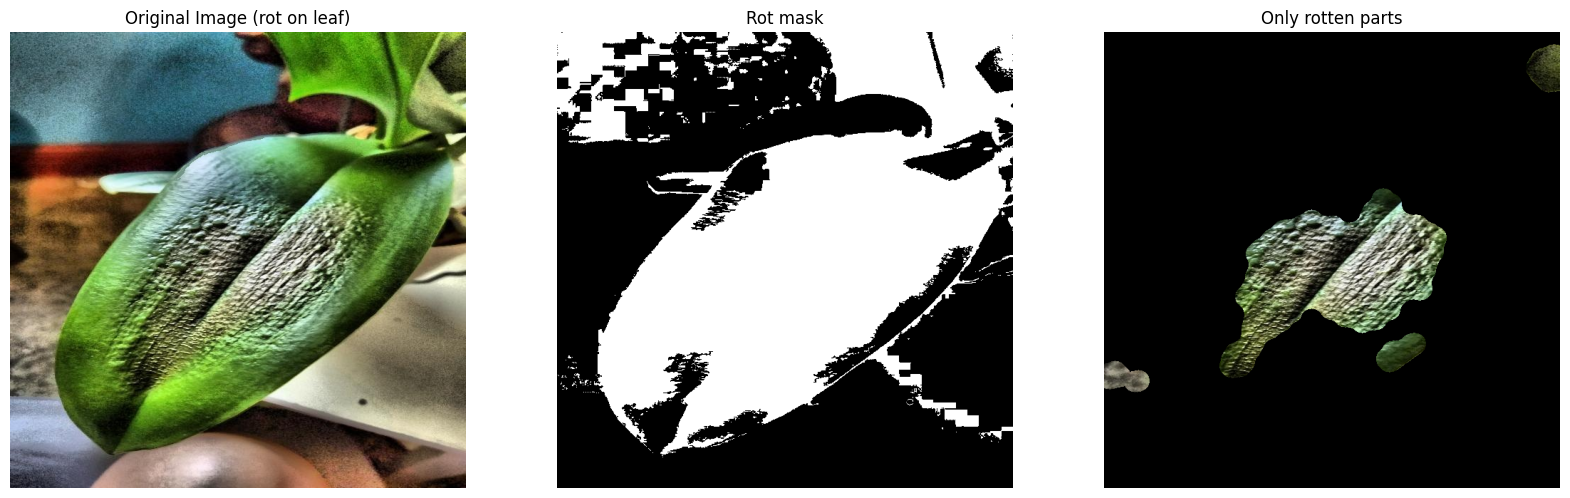

In [134]:
leaf_mask3 = cv2.inRange(hsv_rot, (25, 50, 70), (95, 255, 255)) # Slightly adjusted to fit the rotten leaf color
leaf3 = np.zeros(leaf_mask3.shape, dtype=np.uint8)

rot_rgb = cv2.cvtColor(rot, cv2.COLOR_BGR2RGB)

contours3, _ = cv2.findContours(leaf_mask3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the black image
cv2.drawContours(leaf3, contours3, -1, 255, cv2.FILLED)

rot_mask1 = cv2.inRange(hsv_rot, (5,10,20), (60,120,100))
rot_mask2 = cv2.inRange(hsv_rot, (10,100,10), (20, 255, 200))
rot_mask = cv2.bitwise_or(rot_mask1, rot_mask2)

rot_mask = cv2.bitwise_and(leaf3, leaf3, mask=rot_mask)

kh, kw = [max(9, int(round(min(hsv_aziz_burn.shape[:2]) * 0.01))) | 1]*2 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kh, kw))
rot_mask = cv2.morphologyEx(rot_mask, cv2.MORPH_CLOSE, kernel)
rot_mask = cv2.morphologyEx(rot_mask, cv2.MORPH_OPEN,  kernel)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(rot_rgb)
axes[0].axis('off')
axes[0].set_title("Original Image (rot on leaf)")

axes[1].imshow(leaf3, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Rot mask")

axes[2].imshow(cv2.bitwise_and(rot_rgb, rot_rgb, mask=rot_mask))
axes[2].axis('off')
axes[2].set_title("Only rotten parts")
plt.show()

# Masking yellowing (nutrient deficiency)

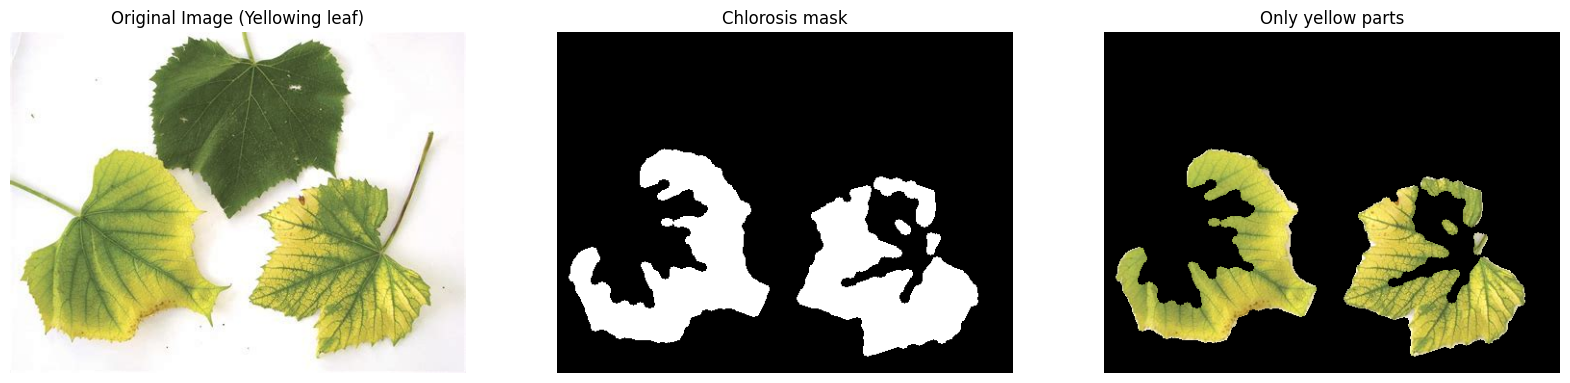

In [ ]:
chlorosis_mask = cv2.inRange(hsv_c1, (23, 50, 10), (35, 255, 255))
c1_rgb = cv2.cvtColor(c1, cv2.COLOR_BGR2RGB)

kh, kw = [max(9, int(round(min(c1.shape[:2]) * 0.01))) | 1]*2 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kh, kw))
chlorosis_mask = cv2.morphologyEx(chlorosis_mask, cv2.MORPH_CLOSE, kernel)
chlorosis_mask = cv2.morphologyEx(chlorosis_mask, cv2.MORPH_OPEN,  kernel)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(c1_rgb)
axes[0].axis('off')
axes[0].set_title("Original Image (Yellowing leaf)")

axes[1].imshow(chlorosis_mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Chlorosis mask")

axes[2].imshow(cv2.bitwise_and(c1_rgb, c1_rgb, mask=chlorosis_mask))
axes[2].axis('off')
axes[2].set_title("Only yellow parts")
plt.show()

# Final pipeline for disease masking

In [ ]:
def color_mask(img_path):
    img = cv2.imread(img_path) # Read the image

    # Convert the color standard to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Find the leaf
    leaf_mask = cv2.inRange(hsv, (25, 100, 70), (65, 255, 255))

    # Create a black 1-channel image to draw on the leaf mask
    leaf = np.zeros(leaf_mask.shape, dtype=np.uint8)

    # Get the outermost contour
    contours, _ = cv2.findContours(leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the black image
    cv2.drawContours(leaf, contours, -1, 255, cv2.FILLED)

    # Construct the powdery mildew mask
    mildew_mask = cv2.inRange(hsv, (0, 0, 180), (180,  60, 255))

    # Construct the spots mask
    spot_mask = cv2.inRange(hsv, (10,100,10), (20, 255, 200))

    # Construct the rot mask
    rot_mask1 = cv2.inRange(hsv, (5,10,20), (60,120,100))
    rot_mask2 = cv2.inRange(hsv, (10,100,10), (20, 255, 200))
    rot_mask = cv2.bitwise_or(rot_mask1, rot_mask2)

    # Combine the mildew, spot and rot masks then confine within the leaf - others can appear on edges
    temp_mask = cv2.bitwise_or(mildew_mask, spot_mask)
    temp_mask = cv2.bitwise_or(temp_mask, rot_mask)
    temp_mask = cv2.bitwise_and(leaf, leaf, mask=temp_mask)

    # Construct the burn mask
    burn_mask = cv2.inRange(hsv, (10,100,10), (20, 255, 200))

    # Construct the chlorosis mask
    chlorosis_mask = cv2.inRange(hsv, (23, 50, 10), (35, 255, 255))

    # Combine disease masks
    disease_mask = cv2.bitwise_or(temp_mask, burn_mask)
    disease_mask = cv2.bitwise_or(disease_mask, chlorosis_mask)

    # Smooth out edges and close gaps in mask
    kh, kw = [max(9, int(round(min(img.shape[:2]) * 0.01))) | 1]*2 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kh, kw))
    disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_CLOSE, kernel)
    disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_OPEN,  kernel)


    return disease_mask


## Helper functions

In [137]:
# # Converting the standard HSV fields to opencv's
# def convert_hsv(h: int, s: int, v: int) -> list[int]:
#     return [round(h/2)] + [round((x/100) * 255) for x in [s, v]]

To inform our HSV based ranges of the colors related to the diseases commonly, we'll run the following cell in a python script to use a mouse callback as a color picker from the training data I have. This will give me a ballpark guess on what colors I'm intrested in.


In [138]:
# import cv2
# import numpy as np

# # Global variables to store the image and picked color
# img = cv2.imread("test_imgs/mildew.jpg")
# picked_color = np.array([0, 0, 0]) # Default to black (BGR)
# hsv_color = np.array([0,0,0])

# # Mouse callback function
# def mouse_callback(event, x, y, flags, param):
#     global picked_color, hsv_color, img

#     if event == cv2.EVENT_LBUTTONDOWN:
#         # Get the BGR color of the pixel at (x, y)
#         picked_color = img[y, x] # Returns a numpy array 
#         hsv_color = cv2.cvtColor(np.uint8([[picked_color]]), cv2.COLOR_BGR2HSV)[0][0]
#         print("--------------------")
#         print(f"Picked BGR color: {picked_color}")
#         print(f"Picked HSV color: {hsv_color}")

# cv2.putText(img, "Click to pick color", (100, 250), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# # Create a window and set the mouse callback
# cv2.namedWindow("Color Picker")
# cv2.setMouseCallback("Color Picker", mouse_callback)

# while True:
#     # Display the image
#     display_img = img.copy()
    
#     # Display the picked color in a rectangle
#     cv2.rectangle(display_img, (10, 10), (100, 50), picked_color.tolist(), -1)
#     cv2.putText(display_img, f"BGR: {picked_color[0]},{picked_color[1]},{picked_color[2]}", (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
#     cv2.putText(display_img, f"HSV: {hsv_color[0]},{hsv_color[1]},{hsv_color[2]}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

#     cv2.imshow("Color Picker", display_img)

#     # Exit on 'q' key press
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()